# Races - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

This notebook study the application of the DBSCAN density-based clustering algorithm on races data.

The approach below includes in the clustering process the 6 features `points`, `length`, `climb_total`, `race_physical_effort`, `race_prestige` and `num_participants`.

The selection of these features was derived from a data understanding process, applied following the data cleaning and feature engeneering phases, through which it was possible to skim the attributes by identifying those that appeared to be the most significant. In particular, thanks to the data representation process (applying UMAP and PCA) these feature emerged as the most "aligned" with the principal components.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

import itertools

In [3]:
races_dataset = pd.read_csv('../../data/races_dataset_no_outliers.csv').drop(['uci_points', 'profile'], axis=1)
races_dataset = races_dataset.select_dtypes(include=['number'])
races_dataset = races_dataset.dropna().reset_index(drop=True)

# Drop colums from PCA and UMAP analisis
races_dataset = races_dataset.drop(['startlist_quality', 'race_year', 'climb_percentage'], axis=1)

races_dataset.info()
columns_to_use = races_dataset.columns

# Standardization of the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(races_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2841 entries, 0 to 2840
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   points                2841 non-null   float64
 1   length                2841 non-null   float64
 2   climb_total           2841 non-null   float64
 3   race_physical_effort  2841 non-null   float64
 4   race_prestige         2841 non-null   float64
 5   num_participants      2841 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 133.3 KB


Thanks to the following model selection process, the two parameters of the ‘DBSCAN’ algorithm (‘eps’ and ‘min_samples’) were selected in the context of this case study. Of the options studied in the process, the evaluation was made according to the trade-off between the number of clusters identified and silhouette score.

Each iteration of the model selection process starts with setting the ‘min_points’ parameter, studied in the range 2-20. For each of these alternatives, the optimal value of the ‘eps’ parameter is identified through the identification of the knee-point in the curve defined by the points (k-th distance, index).

Our Knee Method implementation:

- We compute the 𝑘-distance for each point:
    - Choose a value for 𝑘, a tipical choice should be to set to 𝑘 = min_points − 1, where min_points is the minimum number of points required to form a dense region (DBSCAN parameter fixed in the model selection iteration). 
    - For each point in the dataset, we calculate the distance to its 𝑘-th nearest neighbor (𝑘-distance).
- We sort the 𝑘-distances:
    - Arrange all the points by their 𝑘-distance in a 𝑘-distance plot, where the x-axis is the points (sorted) and the y-axis is their 𝑘-distance.
- Plot the 𝑘-distance graph
- Identify the "knee" in the plot: The y-axis typically increases gradually at first and then sharply increases, forming a curve. The knee corresponds to the point of maximum curvature in the graph. It is the location where the slope changes most significantly. Intuitively, it separates the "dense" regions (gradual slope) from the "sparse" regions (steep slope) in the dataset.


To automate the process of knee detection, we relied on the kneed library (KneeLocator).


#### Model Selection

In [4]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []

for i, value in enumerate(min_points):
    k = value - 1 # Standard value
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")
    
    if(kneedle.knee is None):
        optimal_eps.append(None) 
        optimal_index.append(None)  
        silhouette_scores.append(None)
        continue
    
    # Get the knee (selecting automatically the optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    races_dataset['cluster'] = clusters
    number_of_clusters = races_dataset['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    # Considering that a cluster (label -1) is that of outliers, to compute silhouette we need at least 3 clusters here
    if(number_of_clusters < 3):
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(races_dataset[races_dataset['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

min_points  optimal_eps  optimal_index  cluster_count  silhouette_score
0            2     0.741022           2776             34         -0.016203
1            3     1.052646           2809              7          0.496004
2            4     1.241405           2810              6          0.505526
3            5     1.339942           2807              6          0.515982
4            6     1.052831           2745              4          0.668976
5            7     1.828910           2819              5          0.583449
6            8     1.183753           2753              3          0.749539
7            9     1.127334           2731              3          0.749345
8           10     1.156422           2731              3          0.749319
9           11     1.201476           2739              3          0.749291
10          12     1.237763           2743              3          0.749549
11          13     1.204228           2723              3          0.749242
12          14     1.312882           2754              3          0.746678
13          15     1.314266           2747              3          0.746632
14          16     1.327744           2744              3          0.746373
15          17     1.616549           2776              3          0.744506
16          18     1.366435           2746              3          0.746483
17          19     1.552279           2765              3          0.746838

As seen from these results, selecting min_points = 7 lead the algorithm to the identification of 5 clusters with a better silhouette score respect to other choices permitting the identification of more clusters. This choice offered us a clustering the we found to be more relevant.

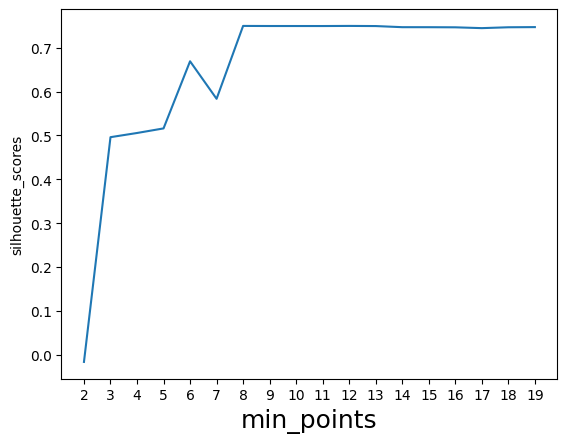

In [5]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameters Clustering

(4034220,)
(2841, 2841)
Optimal epsilon (eps): 1.828910225030442
Knee point index: 2819


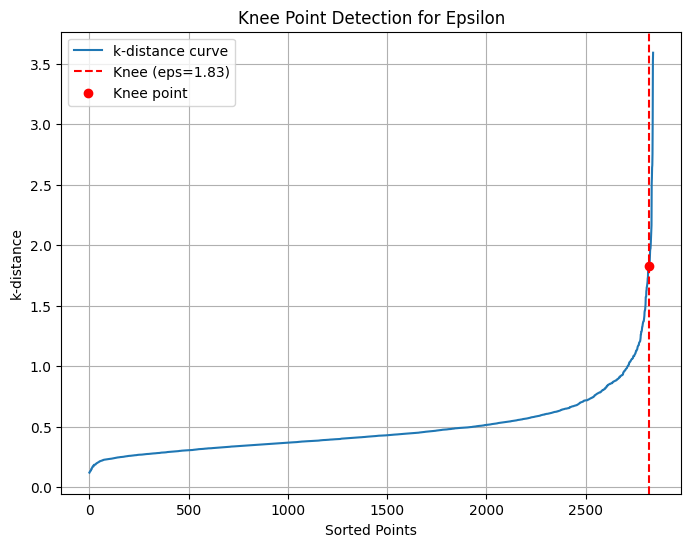

In [6]:
min_points = 7 # Found throught model selection

dist = pdist(data_scaled, 'euclidean') # Pair wise distance
print (dist.shape)
dist = squareform(dist) # Distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 # Standard value
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

Selection of best eps

In [7]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
races_dataset['cluster'] = clusters

# Display cluster distribution
print(races_dataset['cluster'].value_counts())
print(races_dataset.head())

cluster
 0    2768
 1      44
 2      18
 3       7
-1       4
Name: count, dtype: int64
   points  length  climb_total  race_physical_effort  race_prestige  \
0   100.0     5.2        0.027              0.000015       0.193636   
1   100.0   135.0        0.438              0.006662       0.193636   
2   100.0   100.0        0.398              0.004484       0.193636   
3   100.0   199.0        1.847              0.041416       0.193636   
4   100.0   244.0        1.705              0.140635       0.193636   

   num_participants  cluster  
0               110        0  
1               109        0  
2               109        0  
3               108        0  
4               106        0  


In [8]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([   4, 2768,   44,   18,    7]))

In [9]:
# Identify outliers (cluster label -1)
outliers = races_dataset[races_dataset['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 4


In [10]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = races_dataset.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
              points                 length            climb_total            \
               mean        std        mean        std        mean       std   
cluster                                                                       
-1       275.000000   0.000000  268.500000  17.078251    4.291250  0.184978   
 0        77.841402  19.190120  166.228490  56.709790    2.275902  1.297492   
 1       238.636364  22.525532  224.354545  31.166809    2.239659  0.899253   
 2       350.000000   0.000000  264.087778   7.931756    4.197389  0.673144   
 3       350.000000   0.000000  268.865714  12.828427    2.466286  0.583441   

        race_physical_effort           race_prestige            \
                        mean       std          mean       std   
cluster                                                          
-1                  0.543745  0.177736      0.423717  0.211251   
 0                  0.146718  0.154306      0.143053  0.078493   
 1              

In [11]:
def plot_variable_pairs(columns_to_use, dataset):
    '''
    Visualize the relationship between each pair of variables in a DataFrame

    Parameters:
     - columns_to_use (list): List of column names to visualize
     - dataset (DataFrame): DataFrame containing the data to plot
    '''

    pairs = list(itertools.combinations(columns_to_use, 2)) # Create all possible pairs of variables
    n_pairs = len(pairs)
    n_cols = 2
    n_rows = int(np.ceil(n_pairs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

    # If there is only one row of subplots, axes will be a 1D array
    if n_rows == 1:
        axes = axes[np.newaxis, :]
        
    # Plot for each pair of variables
    for (x_var, y_var), ax in zip(pairs, axes.ravel()):
        sns.scatterplot(
            data=dataset,
            x=x_var, y=y_var, hue="cluster", palette="viridis", ax=ax, s=10
        )
        ax.set_title(f'Clusters: {x_var} vs {y_var}')
        ax.legend()

    # Remove empty subplots if n_pairs does not fill the grid
    for ax in axes.ravel()[n_pairs:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

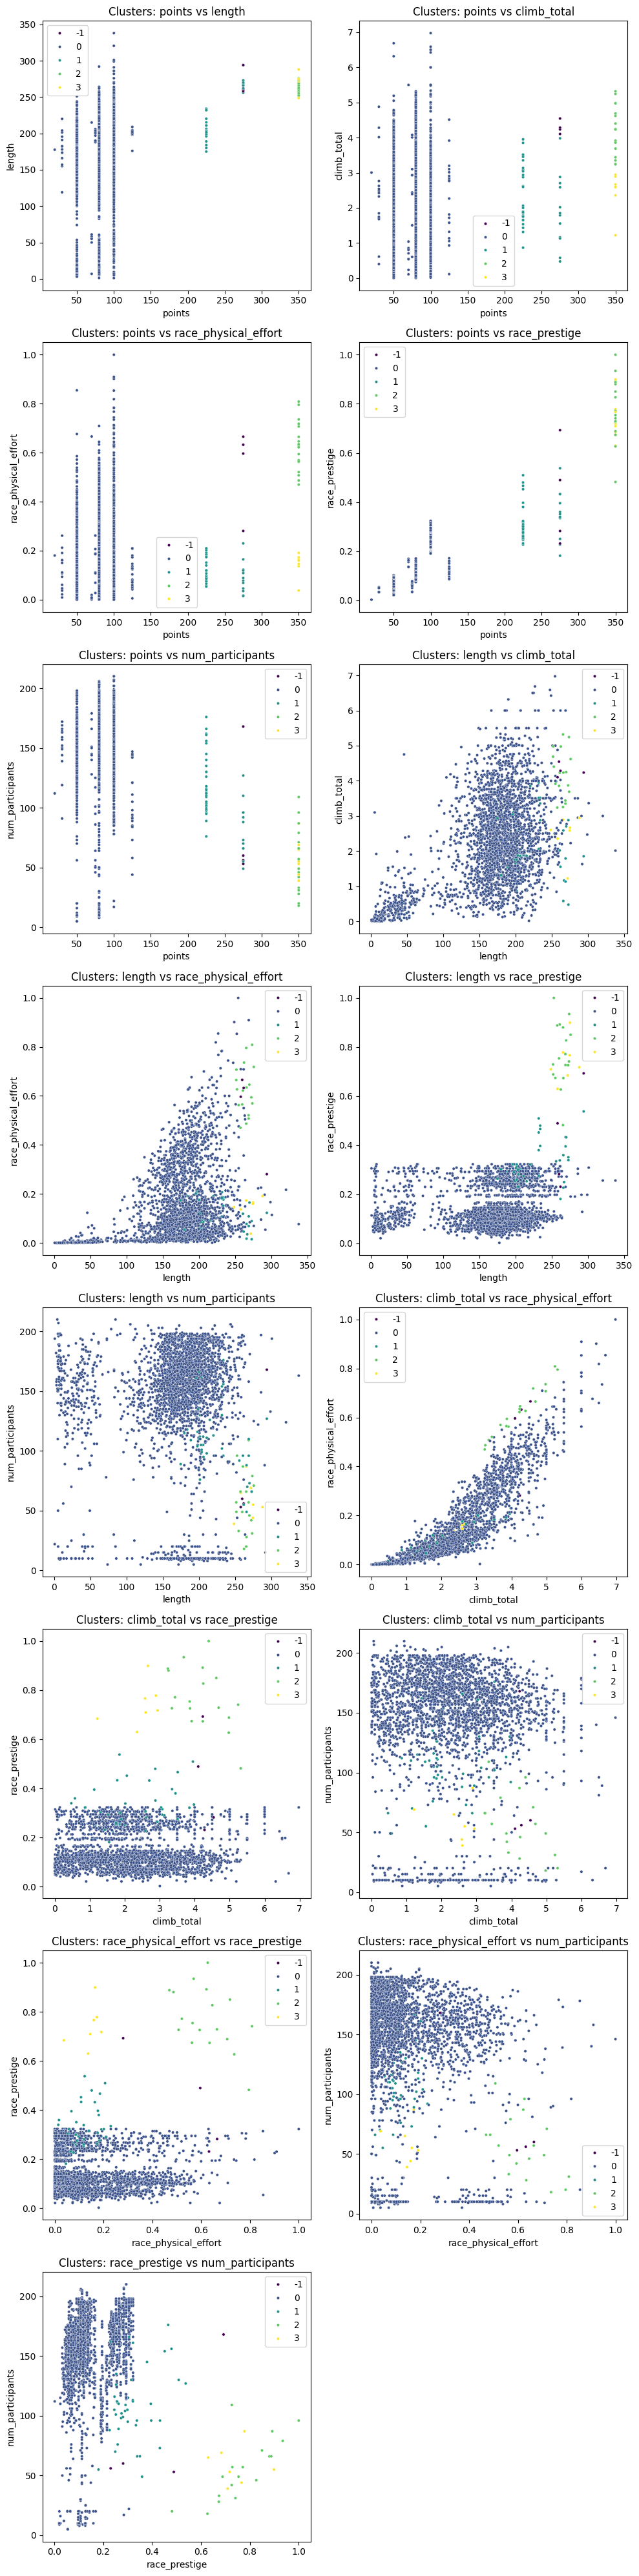

In [12]:
data_subset = races_dataset[list(columns_to_use) + ["cluster"]]
plot_variable_pairs(columns_to_use, data_subset)

In [13]:
def plot_variable_triplets(columns_to_use, dataset):
    '''
    Visualize the relationship between each triplet of variables in a DataFrame

    Parameters:
        - columns_to_use (list): List of column names to visualize
        - dataset (DataFrame): DataFrame containing the data to plot
    '''

    triplets = list(itertools.combinations(columns_to_use, 3)) # Create all possible triplets of variables
    n_triplets = len(triplets)
    n_cols = 2
    n_rows = int(np.ceil(n_triplets / n_cols))

    fig = plt.figure(figsize=(14, 7 * n_rows))

    # Plot for each combination of three variables
    for i, (x_var, y_var, z_var) in enumerate(triplets):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')

        ax.scatter(
            dataset[x_var],
            dataset[y_var],
            dataset[z_var],
            c=dataset["cluster"], cmap="viridis", s=10, zorder=1
        )

        ax.set_title(f'Clusters: {x_var} vs {y_var} vs {z_var}', pad=20)
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)
        ax.set_zlabel(z_var)

    plt.tight_layout()
    plt.show()

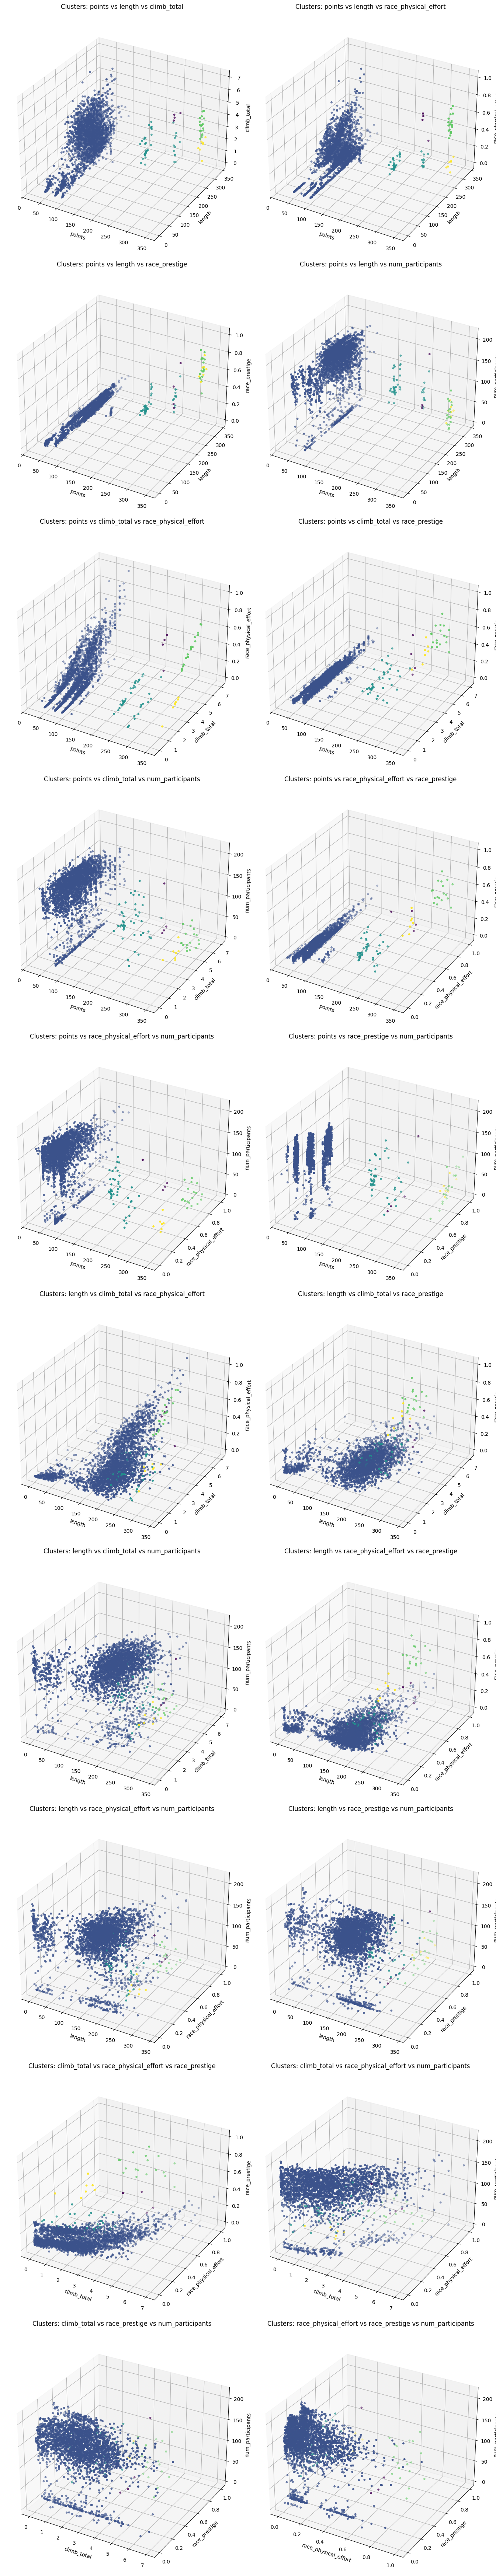

In [14]:
plot_variable_triplets(columns_to_use, data_subset)

The results of the clustering process on races data show that our records are mainly grouped in a single big cluster of points. Thanks to the two features `race_physical_effort` and `points` we can distinguish other three relevant clusters of points (excluding the points labeld as outliers, -1).  

In particular we find that according to `points` races can be distinguished in races offering a sum of points between 0 and 150, between 150 and 300 and over 300. The latter cluster can be also divided in two distinct classes respect to the `race_physical_effort` feature in races requiring a physical effort greater or lower 0.3.


In [15]:
data_scaled = scaler.fit_transform(races_dataset[races_dataset['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

In [16]:
print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.5834490986876973


The silhouette value is not particularly encouraging in this clustering, but we find that this configuration of clusters is still the most interesting between clusterings with more than 0.55 of silhouette score.